# Mnist data set



In [2]:
import os
general_path = r'C:\Users\kmorales\Desktop\3th PhD\PMM SImulations' 
os.chdir(general_path)

In [6]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

import torch
from torch import nn
from torchsummary import summary
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.normal import Normal
import torch.distributions.normal as Norm
import torch.distributions.kl as KL
import torch.nn.functional as F

In [7]:
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  

## Data

In [128]:
#-------------------------------
# Change the name to create or load the data and models
folder_data = 'Data'
data = 'mnist'
if not os.path.exists(os.path.join(general_path, data)):
    print('Creating folder to save models: ', os.path.join(general_path, data))
    os.makedirs(os.path.join(general_path, data))


x_train = np.load(os.path.join(general_path, folder_data,'x_train.npy'))
y_train = np.load(os.path.join(general_path, folder_data,'train_labels.npy'))
x_test = np.load(os.path.join(general_path, folder_data,'x_test.npy'))
y_test = np.load(os.path.join(general_path, folder_data,'test_labels.npy'))
print('shape x train', x_train.shape)
print('shape y train', len(y_train))
print('shape x test', x_test.shape)
print('shape y test', len(y_test))


shape x train (60000, 784)
shape y train 60000
shape x test (10000, 784)
shape y test 10000


In [496]:
#--------------------------------------------
# Digit 0 to 9
digit = 0 # None: all data
#--------------------------------------------
if digit == None:
    trainY = y_train
    testY = y_test
    trainX = x_train
    testX = x_test
else:
    idx =  np.where(y_train==digit)[0]
    trainY, trainX = y_train[idx] ,  x_train[idx]
    idx =  np.where(y_test==digit)[0]
    testY, testX = y_test[idx], x_test[idx]

print('shape train  1', trainX.shape)
print('shape test  1', testX.shape)
    

shape train  1 (5923, 784)
shape test  1 (980, 784)


## Pre-processing for semi-supervised models

In [57]:
from utils.utils_semi import *

In [56]:
# True masks (true binary images)
trainYT, testYT = trainX.copy(), testX.copy()

In [116]:
# #name _01 params = {'p': 0.4, 'mu': 1, 'sigma': 0.25, 'size': 28}
# # without complex noisy images
# p = 0.4 
# mu = 1
# sigma = 0.25
# size = 28
# trainX_seq = semi_sup_preprocessing(trainX, p, mu, sigma, size)
# testX_seq = semi_sup_preprocessing(testX, p, mu, sigma, size)
# np.save(os.path.join(general_path, folder_data,'trainX_seq-01.npy'), trainX_seq)
# np.save(os.path.join(general_path, folder_data,'testX_seq-01.npy'), testX_seq)


In [117]:
x_y_train = np.load(os.path.join(general_path, folder_data,'trainX_seq-01.npy'), allow_pickle=True)
x_y_test = np.load(os.path.join(general_path, folder_data,'testX_seq-01.npy'), allow_pickle=True)

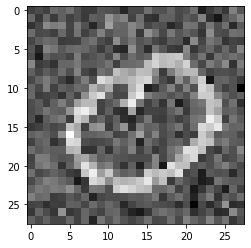

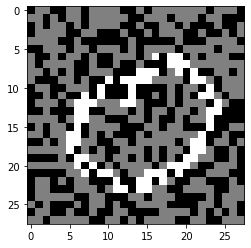

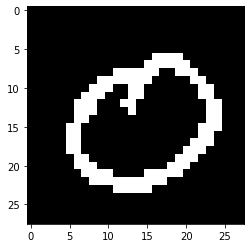

In [83]:
# Example of inputs for the model
idx = 1180
plt.imshow(x_y_train[idx][0], cmap='gray')
plt.show()
plt.imshow(x_y_train[idx][1], cmap='gray')
plt.show()
plt.imshow(trainYT[idx], cmap='gray')
plt.show()

```
 (seq, batch, elem)
[time, batch_size, x_dim]
x_[t] = [batch_size, x_dim]
We take several observations at time t
```

# Semi supervised models




### Creation data loaders

In [222]:
import torch
from torch.utils.data import Dataset

class Seq_Image(Dataset):
    '''
    Images for the semi-supervised model
    '''
    def __init__(self, image_list, image_shape, transforms = None):
        # store the image and mask file
        self.image_list = image_list # [x image, y mask]
        self.transforms = transforms
        self.image_shape =  image_shape
    def __len__(self):
        return len(self.image_list)
        
    
    def __getitem__(self, idx):
        # grab the image path from the current index    
        image  = self.image_list[idx][0].reshape(self.image_shape)
        mask = self.image_list[idx][1].reshape(self.image_shape)
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long) 

       # check to see if we are applying any transformations
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask


In [336]:
# trainX_seq a list of [x, y_missing] where x is the noisy image and y_missing is the image with missing labels
x_y_train = np.load(os.path.join(general_path, folder_data,'trainX_seq-01.npy'), allow_pickle=True)
x_y_test = np.load(os.path.join(general_path, folder_data,'testX_seq-01.npy'), allow_pickle=True)

In [228]:
# batch_sz = 1
# size = 28

# dataset = Seq_Image(x_y_train, (size*size,1))
# dataset_test = Seq_Image(x_y_test, (size*size,1))

# print   (dataset.shape)
# train_loader = torch.utils.data.DataLoader(dataset,batch_sz,shuffle=False)
# # Here we use batch size 1 because we want to have the same size of the input for the model and get a dice score por each image
# test_loader = torch.utils.data.DataLoader(dataset_test,batch_sz,shuffle=False)

# for batch_idx, datos in enumerate(train_loader):
#     x, y = datos
#     x, y = x.to(device), y.to(device)

#     print(x.shape), print(y.shape)
# # for batch_idx, datos in enumerate(train_loader):
# #     x, y = datos
# #     x, y = x.to(device), y.to(device)
# #     x = x.transpose(0, 1).unsqueeze(2)
# #     y = y.transpose(0, 1).unsqueeze(2)
# #     print(x.shape), print(y.shape)

AttributeError: 'Seq_Image' object has no attribute 'shape'

In [140]:
# def train(train_loader, epoch, model, optimizer, batch_sz, clip, print_every,device):
#     '''
#     This function trains the model for one epoch
#     Inputs:
#         train_loader: data loader for the training set
#         epoch: current epoch
#         model: model to train
#         optimizer: optimizer to use
#         batch_sz: batch size
#         clip: gradient clipping
#         print_every: print every n batches
#         device: cpu or gpu
#     Outputs:
#         train_loss: loss for the training set
#     '''
#     train_loss = 0
#     for batch_idx, datos in enumerate(train_loader):
#         x, y = datos
#         x, y = x.to(device), y.to(device)
#         x = x.transpose(0, 1).unsqueeze(2)
#         y = y.transpose(0, 1).unsqueeze(2)
            
#         #forward + backward + optimize
#         optimizer.zero_grad()
    
#         kld_loss_l, rec_loss_l, y_loss_l, kld_loss_u, rec_loss_u, y_loss_u = model(x,y)
#         loss_l = kld_loss_l + rec_loss_l + y_loss_l
#         loss_u = kld_loss_u + rec_loss_u + y_loss_u
#         loss = loss_l + loss_u
#         loss.backward()
#         nn.utils.clip_grad_norm(model.parameters(), clip)
#         optimizer.step()
        
#         #printing
#         if batch_idx % print_every == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\t  Loss Labeled: {:.6f} \t Loss Unlabeled: {:.6f}'.format(
#                 epoch, batch_idx * len(datos), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 loss_l.item()/batch_sz,
#                 loss_u.item()/batch_sz))     
#             print('\n kdl_loss_l: {:.4f} \t rec_loss_l: {:.4f} \t y_loss_l: {:.4f}'.format(kld_loss_l.item()/batch_sz, rec_loss_l.item()/batch_sz, y_loss_l.item()/batch_sz))
#             print('\n kdl_loss_u: {:.4f} \t rec_loss_u: {:.4f} \t y_loss_u: {:.4f}'.format(kld_loss_u.item()/batch_sz, rec_loss_u.item()/batch_sz, y_loss_u.item()/batch_sz))
#         train_loss += loss.item()
        
#     print('')
#     print('Train> Epoch: {} average -ELBO: {:.4f}'.format(epoch, train_loss/ len(train_loader.dataset)))
#     return train_loss/ len(train_loader.dataset)


# def test(test_loader, model):
#     """uses test data to evaluate
#     likelihood of the model"""
#     test_loss = 0
#     Label = 0
#     Unlabel = 0
#     for i, datos in enumerate(test_loader):
#         x, y = datos
#         x, y = x.to(device), y.to(device)
#         x = x.transpose(0, 1).unsqueeze(2)
#         y = y.transpose(0, 1).unsqueeze(2)

#         kld_loss_l, rec_loss_l, y_loss_l, kld_loss_u, rec_loss_u, y_loss_u = model(x,y)
#         loss_l = kld_loss_l + rec_loss_l + y_loss_l
#         loss_u = kld_loss_u + rec_loss_u + y_loss_u
#         loss = loss_l + loss_u
#         loss.backward()
#         nn.utils.clip_grad_norm(model.parameters(), clip)
#         optimizer.step()

#         test_loss += Label + Unlabel
        
#     print('Test Loss:  Loss Labeled: {:.6f} \t Loss Unlabeled: {:.6f}'.format(
#         Label/len(test_loader.dataset),
#         Unlabel/len(test_loader.dataset)))     
    
#     return (test_loss)/len(test_loader.dataset)
    

# def run_model(train_loader,test_loader,model,optimizer,batch_sz,clip, path_save_model, n_epochs ,print_every, device,save_every=5):
#     train_LOSS = []
#     test_LOSS = []
#     path_save = os.path.join(path_save_model, model.__class__.__name__.casefold() +'_state_')
#     print('The model is saved in this path', os.path.join(path_save_model, model.__class__.__name__.casefold()))
#     for epoch in range(1, n_epochs + 1):
#         #training + testing
#         LOSS  = train(train_loader, epoch, model, optimizer, batch_sz, clip, print_every,device)
#         LOSS_T = test(test_loader, model)
        
#         train_LOSS.append(LOSS)
#         test_LOSS.append(LOSS_T)
        
#         #saving model
#         if epoch % save_every == 0:
#             fn = path_save+str(epoch)+'.pth'
#             torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': model.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'loss': LOSS,
#                         }, fn)
#             #torch.save(model.state_dict(), fn)
#             print('Saved model to '+fn)
#         if epoch % print_every == 0:
#             np.save(path_save+'train_'+str(epoch)+'.npy', train_LOSS)
#             np.save(path_save+'val_'+str(epoch)+'.npy', test_LOSS)
            
#     return train_LOSS, test_LOSS




In [263]:
def run_model_seq(x, y,model,optimizer,clip, path_save_model, n_epochs , device,save_every=5):
    train_LOSS = []
    path_save = os.path.join(path_save_model, model.__class__.__name__.casefold() +'_state_')
    print('The model is saved in this path', os.path.join(path_save_model, model.__class__.__name__.casefold()))
    for epoch in range(1, n_epochs + 1):
        #training 
        kld_loss_l, rec_loss_l, y_loss_l, kld_loss_u, rec_loss_u, y_loss_u = model(x,y)
        loss_l = kld_loss_l + rec_loss_l + y_loss_l
        loss_u = kld_loss_u + rec_loss_u + y_loss_u        
        loss = loss_l + loss_u
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        train_LOSS.append(loss.item())
        
        #saving model
        if epoch % save_every == 0:
            print('Loss Labeled: {:.6f} \t Loss Unlabeled: {:.6f}'.format(
                    loss_l.item(), loss_u.item()))     
            print('\n kdl_loss_l: {:.4f} \t rec_loss_l: {:.4f} \t y_loss_l: {:.4f}'.format(kld_loss_l.item(), rec_loss_l.item(), y_loss_l.item()))
            print('\n kdl_loss_u: {:.4f} \t rec_loss_u: {:.4f} \t y_loss_u: {:.4f}'.format(kld_loss_u.item(), rec_loss_u.item(), y_loss_u.item()))
    
            fn = path_save+str(epoch)+'.pth'
            torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': LOSS,
                        }, fn)
            #torch.save(model.state_dict(), fn)
            print('Saved model to '+fn)
            np.save(path_save+'train_'+str(epoch)+'.npy', train_LOSS)
            
    return train_LOSS



## Check of dimensions

In [320]:
x_dim = 1
z_dim = 25
h_dim = 20
y_dim = 1
n_layers = 1
bias=False

from torch import nn
from torchsummary import summary
import torch

Soft_threshold = nn.Sigmoid()

# Prior p(z_t | y_t, h_{t-1}) = N (μt, σt)
prior_z = nn.Sequential( nn.Linear(h_dim + y_dim, h_dim),
                            nn.ReLU())

prior_z_mean = nn.Linear(h_dim, z_dim)

prior_z_std = nn.Sequential( nn.Linear (h_dim, z_dim), 
                            nn.Softplus())

# Prior p(y_t | h_{t-1}) = Cat (θt) 
# In this case, we use a linear layer to predict the logits of the categorical distribution
# We will use the sigmoid function to ensure that the logits are positive and only two classes
# it means a Bernoulli distribution.
prior_y = nn.Sequential( nn.Linear(h_dim, h_dim ),
                        nn.ReLU(),
                        nn.Linear(h_dim , h_dim ),
                        nn.ReLU())

prior_y_proba = nn.Sequential(nn.Linear(h_dim, h_dim ),
                                nn.ReLU(),
                                nn.Linear(h_dim, y_dim),
                                nn.Sigmoid())

# q(y_t | x_t, h_{t-1}) = Cat (θt)
q_y = nn.Sequential( nn.Linear(x_dim + h_dim, h_dim ),
                        nn.ReLU(),
                        nn.Linear(h_dim , h_dim ),
                        nn.ReLU())

q_y_proba = nn.Sequential(nn.Linear(h_dim, h_dim ),
                                nn.ReLU(),
                                nn.Linear(h_dim, y_dim),
                                nn.Sigmoid())


# Encoder
# q(z_t | x_t, y_t, h_{t-1}) = N (μt, σt)
enc = nn.Sequential( nn.Linear(h_dim + x_dim + y_dim, h_dim),
                        nn.ReLU(),
                        nn.Linear(h_dim, h_dim),
                        nn.ReLU())

enc_mean = nn.Linear(h_dim, z_dim)
enc_std = nn.Sequential( nn.Linear (h_dim, z_dim), 
                            nn.Softplus())

# Decoder
# p(x_t | z_t, y_t, h_{t-1}) = N (μt, σt)
dec = nn.Sequential( nn.Linear(h_dim + z_dim + y_dim, h_dim),
                        nn.ReLU(),
                        nn.Linear(h_dim, h_dim),
                        nn.ReLU())

dec_mean = nn.Linear(h_dim, x_dim)
dec_std = nn.Sequential( nn.Linear (h_dim, x_dim), 
                            nn.Softplus())
# Recurrence
# h_t = f(h_{t-1}, x_t, y_t, z_t)
# Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
rnn = nn.RNNCell( x_dim + z_dim + y_dim, h_dim, bias,nonlinearity='tanh')#nn.GRU( h_dim + x_dim + z_dim + y_dim , h_dim, n_layers)
# summary(prior_z)
# summary(prior_z_mean)
# summary(prior_z_std)

def _nll_ber( mean, x):
        nll_loss = F.binary_cross_entropy(mean, x, reduction='sum')
        return nll_loss
    
def _rec_gauss( x, mean, std):
    rec_loss = torch.sum(0.5 * torch.log(2 * np.pi * std**2) + (x - mean)**2 / (2 * std**2))
    return rec_loss

def _kld_gauss( mean_1, std_1, mean_2, std_2):
    norm_dis2 = Norm.Normal(mean_2, std_2)
    norm_dis1 = Norm.Normal(mean_1, std_1)
    kl_loss = torch.sum(KL.kl_divergence(norm_dis1, norm_dis2))
    return    kl_loss

def _kld_cat( q, p):
    kl_loss = torch.sum(q * torch.log(q/p)+ (1-q) * torch.log((1-q)/(1-p)))
    return kl_loss
def _reparameterized_sample( mean, std):
    """using std to sample"""
    eps = torch.FloatTensor(std.size()).normal_()
    #eps = Variable(eps)
    return eps.mul(std).add_(mean)

def _reparameterized_sample_Gumbell( mean):
    """using std to sample"""
    eps = torch.rand(mean.size())  #torch.FloatTensor(mean.size()).uniform()
    #eps = Variable(eps)
    value = torch.log(eps) - torch.log(1-eps) + torch.log(mean) - torch.log(1-mean)
    return Soft_threshold(value)

def encoder( x, y, h):
    input_enc = torch.cat([x, y, h], 0)
    enc_v = enc(input_enc)
    enc_mean_v = enc_mean(enc_v)
    enc_std_v = enc_std(enc_v)
    return enc_mean_v, enc_std_v

def decoder( z, y, h):
    input_dec = torch.cat([z, y, h], 0)
    dec_ = dec(input_dec)
    dec_mean_ = dec_mean(dec_)
    dec_std_ = dec_std(dec_)
    return dec_mean_, dec_std_


In [342]:
x_y_train = np.load(os.path.join(general_path, folder_data,'trainX_seq-01.npy'), allow_pickle=True)
x_y_test = np.load(os.path.join(general_path, folder_data,'testX_seq-01.npy'), allow_pickle=True)

idex = 50
x  = x_y_train[idx][0].reshape((size*size,1))
y = x_y_train[idx][1].reshape((size*size,1))
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long) 
h_t = torch.zeros(1, h_dim)
print('x: ', x.size())
print('y: ', y.size())

x:  torch.Size([784, 1])
y:  torch.Size([784, 1])


In [373]:
h_t = torch.zeros(h_dim)
print('x: ', x.size())
print('y: ', y.size())
print('h_t: ', h_t.size())

rnn = nn.RNNCell( x_dim + z_dim + y_dim, h_dim, bias,nonlinearity='tanh')#nn.GRU( h_dim + x_dim + z_dim + y_dim , h_dim, n_layers)

t = 548
y[t] = -1
p_yt = prior_y_proba(prior_y(h_t))
print('p_yt: ', p_yt.shape)
print('y_t : ', y[t].shape, y[t])
if y[t] == -1:
    q_yt = q_y_proba(q_y( torch.cat([x[t], h_t], 0)))
    print('q_yt: ', q_yt.shape)
    #  # Sample y_t ~ q(y_t | x_t, h_{t-1})
    y_t = _reparameterized_sample_Gumbell(q_yt)
    y[t] = y_t
    
    input_pz =  torch.cat([y[t], h_t], 0)
    print('input_pz: ', input_pz.shape)
    prior_zt = prior_z(input_pz)
    print('prior_zt: ', prior_zt.shape)
    prior_zt_mean = prior_z_mean(prior_zt)
    print('prior_zt_mean: ', prior_zt_mean.shape)
    prior_zt_std = prior_z_std(prior_zt)
    print('prior_zt_std: ', prior_zt_std.shape)
    # # Encoder q(z_t | x_t, y_t, h_{t-1})
    enc_mean_v, enc_std_v = encoder(x[t], y[t], h_t)
    print('enc_mean: ', enc_mean_v.shape)
    print('enc_std: ', enc_std_v.shape)
    z_t = _reparameterized_sample(enc_mean_v, enc_std_v)
    print('z_t: ', z_t.shape)
    # # Decoder p(x_t | z_t, y_t, h_{t-1})
    dec_mean_, dec_std_ = decoder(z_t, y[t], h_t)
    # # Loss
    kld_loss_l = _kld_gauss(enc_mean_v, enc_std_v, prior_zt_mean, prior_zt_std)
    rec_loss_l = _rec_gauss(x[t], dec_mean_, dec_std_)
    print('kld_loss_l: ', kld_loss_l)
    print('rec_loss_l: ', rec_loss_l)
    y_loss_u = _kld_cat(p_yt, q_yt)
    print('y_loss_u: ', y_loss_u)
    # y_loss_l = _nll_ber(p_yt, y[t].float())
    # print('y_loss_l: ', y_loss_l)
    rnn_input = torch.cat([y[t], z_t, x[t-1]], 0)[None, :]
    print('rnn_input: ', rnn_input.size())
    print('h_t: ', h_t.unsqueeze(0).size())
    # h_t = torch.zeros(h_dim)
    h_t = rnn(rnn_input, h_t[None,:])
    
      

x:  torch.Size([784, 1])
y:  torch.Size([784, 1])
h_t:  torch.Size([20])
p_yt:  torch.Size([1])
y_t :  torch.Size([1]) tensor([-1])
q_yt:  torch.Size([1])
input_pz:  torch.Size([21])
prior_zt:  torch.Size([20])
prior_zt_mean:  torch.Size([25])
prior_zt_std:  torch.Size([25])
enc_mean:  torch.Size([25])
enc_std:  torch.Size([25])
z_t:  torch.Size([25])
kld_loss_l:  tensor(1.4692, grad_fn=<SumBackward0>)
rec_loss_l:  tensor(0.5937, grad_fn=<SumBackward0>)
y_loss_u:  tensor(0.0012, grad_fn=<SumBackward0>)
rnn_input:  torch.Size([1, 27])
h_t:  torch.Size([1, 20])


## General Settings

In [402]:
x_dim = 1
y_dim = 1

# Dimension of latent variables
z_dim = 10
h_dim = 20
n_samples = 0
n_layers = 1

# Model settings
learning_rate = 0.003  #0.001
weight_decay_ = 1e-4
n_layers =  1
n_epochs = 100
clip = 10
#--------------------------------------------
# Manual seed
seed = 123
torch.manual_seed(seed)
#--------------------------------------------
# Print settings
print_every = 100
#--------------------------------------------
# Save models
save_every = 5
path_save = os.path.join(general_path, data)
print(f'Actual path to save our models for {data} is {path_save} ')

Actual path to save our models for mnist is C:\Users\kmorales\Desktop\3th PhD\PMM SImulations\mnist 


In [481]:
import numpy as np
import torch
from torch import nn
from scipy.special import logsumexp
import torch.distributions.normal as Norm
import torch.distributions.kl as KL
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
import math
EPS = torch.finfo(torch.float).eps 
c = - 0.5 * math.log(2*math.pi)
class SeqModel(nn.Module):
    def __init__(self, x_dim, z_dim, h_dim, n_layers, y_dim, device, n_samples, bias = False):
        super(SeqModel, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.device = device
        self.y_dim = y_dim
        self.n_samples = n_samples
        self.Soft_threshold = nn.Sigmoid()

        # Prior p(z_t | y_t, h_{t-1}) = N (μt, σt)
        self.prior_z = nn.Sequential( nn.Linear(self.h_dim + self.y_dim, self.h_dim),
                                  nn.ReLU())
        
        self.prior_z_mean = nn.Linear(self.h_dim, self.z_dim)
        
        self.prior_z_std = nn.Sequential( nn.Linear (self.h_dim, self.z_dim), 
                                    nn.Softplus())
        
        # Prior p(y_t | h_{t-1}) = Cat (θt) 
        # In this case, we use a linear layer to predict the logits of the categorical distribution
        # We will use the sigmoid function to ensure that the logits are positive and only two classes
        # it means a Bernoulli distribution.
        self.prior_y = nn.Sequential( nn.Linear(self.h_dim, self.h_dim ),
                                nn.ReLU(),
                                nn.Linear(self.h_dim , self.h_dim ),
                                nn.ReLU())
        
        self.prior_y_proba = nn.Sequential(nn.Linear(self.h_dim, self.h_dim ),
                                      nn.ReLU(),
                                      nn.Linear(self.h_dim, self.y_dim),
                                      nn.Sigmoid())
        
        # q(y_t | x_t, h_{t-1}) = Cat (θt)
        self.q_y = nn.Sequential( nn.Linear(self.x_dim + self.h_dim, self.h_dim ),
                                nn.ReLU(),
                                nn.Linear(self.h_dim , self.h_dim ),
                                nn.ReLU())
        
        self.q_y_proba = nn.Sequential(nn.Linear(self.h_dim, self.h_dim ),
                                      nn.ReLU(),
                                      nn.Linear(self.h_dim, self.y_dim),
                                      nn.Sigmoid())

        
        # Encoder
        # q(z_t | x_t, y_t, h_{t-1}) = N (μt, σt)
        self.enc = nn.Sequential( nn.Linear(self.h_dim + self.x_dim + self.y_dim, self.h_dim),
                                nn.ReLU(),
                                nn.Linear(self.h_dim, self.h_dim),
                                nn.ReLU())
        
        self.enc_mean = nn.Linear(self.h_dim, self.z_dim)
        self.enc_std = nn.Sequential( nn.Linear (self.h_dim, self.z_dim), 
                                    nn.Softplus())
        
        # Decoder
        # p(x_t | z_t, y_t, h_{t-1}) = N (μt, σt)
        self.dec = nn.Sequential( nn.Linear(self.h_dim + self.z_dim + self.y_dim, self.h_dim),
                                nn.ReLU(),
                                nn.Linear(self.h_dim, self.h_dim),
                                nn.ReLU())
        
        self.dec_mean = nn.Linear(self.h_dim, self.x_dim)
        self.dec_std = nn.Sequential( nn.Linear (self.h_dim, self.x_dim), 
                                    nn.Softplus())
        # Recurrence
        # Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
        self.rnn = nn.RNNCell( self.x_dim + self.z_dim + self.y_dim, self.h_dim, bias, nonlinearity='tanh')#nn.GRU( h_dim + x_dim + z_dim + y_dim , h_dim, n_layers)


    def encoder(self, x, y, h):
        input_enc = torch.cat([x, y, h], 0)
        enc = self.enc(input_enc)
        enc_mean = self.enc_mean(enc)
        enc_std = self.enc_std(enc)
        return enc_mean, enc_std
    
    def decoder(self, z, y, h):
        input_dec = torch.cat([z, y, h], 0)
        dec = self.dec(input_dec)
        dec_mean = self.dec_mean(dec)
        dec_std = self.dec_std(dec)
        return dec_mean, dec_std
    
    def get_cost_labeled(self, x, y, h):
        # Prior p(z_t | y_t, h_{t-1})
        input_pz =  torch.cat([y, h], 0)
        prior_zt = self.prior_z(input_pz)
        prior_zt_mean = self.prior_z_mean(prior_zt)
        prior_zt_std = self.prior_z_std(prior_zt)
        # Encoder q(z_t | x_t, y_t, h_{t-1})
        enc_mean, enc_std = self.encoder(x, y, h)
        z_t = self._reparameterized_sample(enc_mean, enc_std)
        # Decoder p(x_t | z_t, y_t, h_{t-1})
        dec_mean, dec_std = self.decoder(z_t, y, h)
        # Loss
        kld_loss_l = self._kld_gauss(enc_mean, enc_std, prior_zt_mean, prior_zt_std)
        rec_loss_l = self._rec_gauss(x, dec_mean, dec_std)
        
        return kld_loss_l, rec_loss_l, z_t

        
    def forward(self, x, y):
        h_t = torch.zeros(self.h_dim).to(self.device)
        kld_loss_l = 0
        rec_loss_l = 0
        y_loss_l = 0

        kld_loss_u = 0
        rec_loss_u = 0
        y_loss_u = 0
        for t in range(x.size(0)):
            # Prior p(y_t | h_{t-1})
            p_yt = self.prior_y_proba(self.prior_y(h_t))            
            if y[t] != -1:
                kld_loss, rec_loss, z_t = self.get_cost_labeled(x[t], y[t], h_t)
                kld_loss_l += kld_loss 
                rec_loss_l += rec_loss
                y_loss_l += self._nll_ber(p_yt, y[t])
            else:
                # q(y_t | x_t, h_{t-1})
                q_yt = self.q_y_proba(self.q_y(torch.cat([x[t], h_t], 0)))
                # Sample y_t ~ q(y_t | x_t, h_{t-1})
                y_t = self._reparameterized_sample_Gumbell(q_yt)
                # loss
                kld_loss, rec_loss, z_t = self.get_cost_labeled(x[t], y_t, h_t)
                kld_loss_u += kld_loss
                rec_loss_u += rec_loss
                y_loss_u += self._kld_cat(p_yt, q_yt)
            # Recurrent h_t = f(h_{t-1}, y_t, z_t, x_{t-1})
            if t==0:
                h_t = self.rnn(torch.cat([y[t], z_t, 0*x[t-1]], 0)[None, :], h_t[None, :]).squeeze(0)
            else:
                h_t = self.rnn(torch.cat([y[t], z_t, x[t-1]], 0)[None, :], h_t[None, :]).squeeze(0)
        return kld_loss_l, rec_loss_l, y_loss_l, kld_loss_u, rec_loss_u, y_loss_u
        

    def _nll_ber(self, mean, x):
        nll_loss = F.binary_cross_entropy(mean, x, reduction='sum')
        return nll_loss
    
    # def _nll_gauss(self, mean, std, x):
    #     return torch.sum(torch.log(std + EPS) + torch.log(2*torch.pi)/2 + (x - mean).pow(2)/(2*std.pow(2)))

    def _rec_gauss(self, x, mean, std):
        rec_loss = torch.sum(c + torch.log(std) + (x - mean)**2 / (2 * std**2))
        return rec_loss
    
    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        norm_dis2 = Norm.Normal(mean_2, std_2)
        norm_dis1 = Norm.Normal(mean_1, std_1)
        kl_loss = torch.sum(KL.kl_divergence(norm_dis1, norm_dis2))
        return    kl_loss
    
    def _kld_cat(self, q, p):
        kl_loss = torch.sum(q * torch.log(q/p)+ (1-q) * torch.log((1-q)/(1-p)))
        return kl_loss
    
    def reset_parameters(self, stdv = 0.1):
        for weight in self.parameters():
            weight.normal_(0, stdv)
            #weight.data.normal_(0, stdv)
            
    # Extra functions 
    def _init_weights(self, stdv):
        pass
    
    def _reparameterized_sample(self, mean, std):
        """using std to sample"""
        eps = torch.FloatTensor(std.size()).normal_()
        #eps = Variable(eps)
        return eps.mul(std).add_(mean)
    
    def _reparameterized_sample_Gumbell(self, mean):
        """using std to sample"""
        #eps = torch.FloatTensor(mean.size()).uniform()
        eps = eps = torch.rand(mean.size()) 
        #eps = Variable(eps)
        value = torch.log(eps) - torch.log(1-eps) + torch.log(mean) - torch.log(1-mean)
        return self.Soft_threshold(value)
    
    def sample(self, x, y):
        '''
        Complete image
        '''
        h_t = torch.zeros(self.h_dim).to(self.device)
        y_complete = y.clone()
        for t in range(x.size(0)):          
            if y[t] != -1:
                enc_mean, enc_std = self.encoder(x[t], y[t], h_t)
                z_t = self._reparameterized_sample(enc_mean, enc_std)
            else:                
                q_yt = self.q_y_proba(self.q_y(torch.cat([x[t], h_t], 0)))
                l_x_t = Bernoulli(q_yt)
                y_t = l_x_t.sample() 
                #print(y_t)
                y_complete[t] = y_t.item()                
                enc_mean, enc_std = self.encoder(x[t], y[t], h_t)
                z_t = self._reparameterized_sample(enc_mean, enc_std)
                
            if t==0:
                h_t = self.rnn(torch.cat([y[t], z_t, 0*x[t-1]], 0)[None, :], h_t[None, :]).squeeze(0)
            else:
                h_t = self.rnn(torch.cat([y[t], z_t, x[t-1]], 0)[None, :], h_t[None, :]).squeeze(0)
        return y_complete
    
    

In [482]:
model = SeqModel(x_dim, z_dim, h_dim, n_layers, y_dim, device, n_samples)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
# print(summary(model))

In [533]:
size = 28
idx = 1520
x  = x_y_train[idx][0].reshape(size*size, 1)
y = x_y_train[idx][1].reshape(size*size, 1)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [483]:
def run_model_seq(x, y,model,optimizer,clip, path_save_model, n_epochs , device,save_every=5):
    train_LOSS = []
    path_save = os.path.join(path_save_model, model.__class__.__name__.casefold() +'_state_')
    print('The model is saved in this path', os.path.join(path_save_model, model.__class__.__name__.casefold()))
    for epoch in range(1, n_epochs + 1):
        #training 
        kld_loss_l, rec_loss_l, y_loss_l, kld_loss_u, rec_loss_u, y_loss_u = model(x,y)
        loss_l = kld_loss_l + rec_loss_l + y_loss_l
        loss_u = kld_loss_u + rec_loss_u + y_loss_u        
        loss = loss_l + loss_u
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        train_LOSS.append(loss.item())
        #saving model
        if epoch % save_every == 0:
            print('Loss Labeled: {:.6f} \t Loss Unlabeled: {:.6f}'.format(
                    loss_l.item(), loss_u.item()))     
            # print('\n kdl_loss_l: {:.4f} \t rec_loss_l: {:.4f} \t y_loss_l: {:.4f}'.format(kld_loss_l.item(), rec_loss_l.item(), y_loss_l.item()))
            # print('\n kdl_loss_u: {:.4f} \t rec_loss_u: {:.4f} \t y_loss_u: {:.4f}'.format(kld_loss_u.item(), rec_loss_u.item(), y_loss_u.item()))
            fn = path_save+str(epoch)+'.pth'
            torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item(),
                        }, fn)
            #torch.save(model.state_dict(), fn)
            # print('Saved model to '+fn)
            np.save(path_save+'train_'+str(epoch)+'.npy', train_LOSS)     
    return train_LOSS

In [450]:
loss = run_model_seq(x, y,model,optimizer,clip, path_save, n_epochs , device,save_every=5)

The model is saved in this path C:\Users\kmorales\Desktop\3th PhD\PMM SImulations\mnist\seqmodel


<ipython-input-448-7a8b06f81398>:12: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


Loss Labeled: -442.004211 	 Loss Unlabeled: -391.683624
Loss Labeled: -486.769592 	 Loss Unlabeled: -386.897034
Loss Labeled: -510.642212 	 Loss Unlabeled: -394.558685
Loss Labeled: -539.694458 	 Loss Unlabeled: -408.817200
Loss Labeled: -580.172241 	 Loss Unlabeled: -387.373535
Loss Labeled: -619.223267 	 Loss Unlabeled: -380.237610
Loss Labeled: -640.079956 	 Loss Unlabeled: -380.742432
Loss Labeled: -646.418457 	 Loss Unlabeled: -411.804321
Loss Labeled: -659.017578 	 Loss Unlabeled: -435.564240
Loss Labeled: -666.295044 	 Loss Unlabeled: -428.880219
Loss Labeled: -667.960205 	 Loss Unlabeled: -448.443756
Loss Labeled: -672.292908 	 Loss Unlabeled: -410.919891
Loss Labeled: -668.016602 	 Loss Unlabeled: -445.140411
Loss Labeled: -680.937866 	 Loss Unlabeled: -448.449188
Loss Labeled: -677.561890 	 Loss Unlabeled: -440.298309
Loss Labeled: -686.622192 	 Loss Unlabeled: -433.543701
Loss Labeled: -681.107788 	 Loss Unlabeled: -414.163910
Loss Labeled: -682.037842 	 Loss Unlabeled: -447

In [484]:
def final_model(model, optimizer, epoch_model, path_save, data,print_loss =True):
    print('Actual  path for to initialize our models: ', path_save)
    path = os.path.join(path_save, model.__class__.__name__.casefold()+'_state_'+str(epoch_model)+'.pth') 
    print(path)
    checkpoint = torch.load(path)
    print(f'Initialization of the {model.__class__.__name__} model  at epoch {epoch_model}')

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    if print_loss:
        print(f'loss: {loss} and epoch: {epoch}')
    return model

In [485]:
#-----------------------------------------------------
model = SeqModel(x_dim, z_dim, h_dim, n_layers, y_dim, device, n_samples)
epoch_model = 100
#-----------------------------------------------------
model = final_model(model, optimizer, epoch_model, path_save, data)

Actual  path for to initialize our models:  C:\Users\kmorales\Desktop\3th PhD\PMM SImulations\mnist
C:\Users\kmorales\Desktop\3th PhD\PMM SImulations\mnist\seqmodel_state_100.pth
Initialization of the SeqModel model  at epoch 100
loss: -1112.096923828125 and epoch: 100


In [523]:
def creation_noisy_image(img, mu, sigma,p,  size = 28, complex = False):
    '''
    image: image of size 28*28
    Binary mask: 0 if the pixel is the background, 1 otherwise (part of the number)
    
    chain: chain of the image (Hilbert curve) which is a vector of size size*size 
    z =  N(0, 1) # random variable wich
    x = z* N(mu, sigma)

    return:
    image_x: image with noise (28*28)
    label_miss: input image with missing labels (28*28)
    '''
    # We use np.pad to add a border of 0 to the image and increase the size to 32*32 beacause:
    # 1D sequence <-> image, using an hilbert curve requires the sequence have length equal to a --power of 2--    
    # This is not a general solution, but it works for the MNIST dataset
    image = np.pad(img.reshape(size, size), ((2,2), (2,2)), 'constant')
    chain = image_to_chain(image)
    # More complex noisy image
    # mu*(chain[i]) is the mean of the normal distribution and it changes for each pixel with respect to the label at that pixel
    if complex:
        z = np.random.normal(size = len(chain))
        x = np.array([  z[i]*np.random.normal(mu*(chain[i]), sigma, 1) for i in range(len(chain)) ])
    else:
        x = np.array([np.random.normal(mu*(chain[i]), sigma, 1) for i in range(len(chain)) ])
    
     # In order to recuperate the original image we need to remove the first 2 and last 2 elements of the chain
    image_x = chain_to_image(x)[2:(2+size), 2:(2+size)]
    mask_missing = np.random.choice([0,1], size=(size, size), p=[p, 1-p])
    label_miss = img.reshape(size, size).copy()
    label_miss[mask_missing==0] = -1
    return [image_x, label_miss]

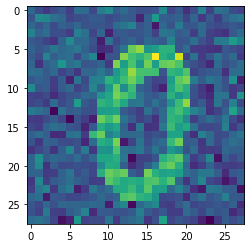

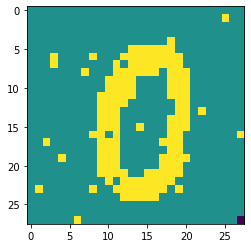

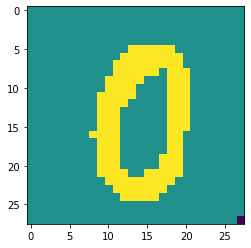

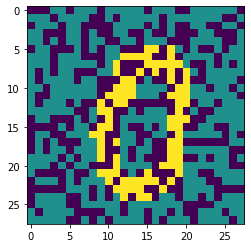

In [536]:
y_ = model.sample(x,y)
image_complete = y_.detach().numpy().reshape(28,28)
image_complete[size-1,size-1] = -1
image_labeled = trainX[idx].reshape(28,28)
image_labeled[size-1,size-1] = -1
plt.imshow(x.detach().numpy().reshape(28,28))
plt.show()
plt.imshow(image_complete)
plt.show()
plt.imshow(image_labeled)
plt.show()

plt.imshow(y.detach().numpy().reshape(28,28))
plt.show()


<ipython-input-532-2489bd117577>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float32)
<ipython-input-532-2489bd117577>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y1 = torch.tensor(y1, dtype=torch.float32)


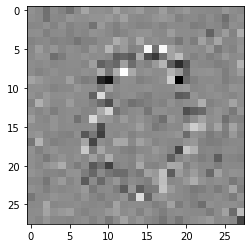

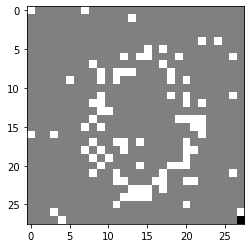

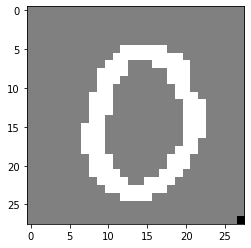

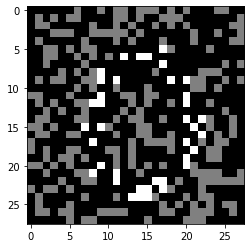

In [532]:
p = 0.65
complex = True
size = 28
idx = 480
x1, y1 = creation_noisy_image(trainX[idx], mu, sigma,p,  size = 28, complex = complex)
x1 = torch.tensor(x1.reshape(size*size, 1), dtype=torch.float32)
y1 = torch.tensor(y1.reshape(size*size, 1), dtype=torch.float32)

x1 = torch.tensor(x1, dtype=torch.float32)
y1 = torch.tensor(y1, dtype=torch.float32)

y1_ = model.sample(x1,y1)
image_complete = y1_.detach().numpy().reshape(28,28)
image_labeled = trainX[idx].reshape(28,28)
image_labeled[size-1,size-1] = -1
image_complete[size-1,size-1] = -1
plt.imshow(x1.detach().numpy().reshape(28,28), cmap='gray')
plt.show()
plt.imshow(image_complete, cmap='gray')
plt.show()
plt.imshow(image_labeled, cmap='gray')
plt.show()
plt.imshow(y1.detach().numpy().reshape(28,28), cmap='gray')
plt.show()


# Generative Models
based on https://github.com/emited/VariationalRecurrentNeuralNetwork

In [ ]:
from utils.utils import *

In [70]:
#--------------------------------------------
# img = True images of 28*28 (generative model)
# img = False  images of 1*784 (seq case)
img = True
if img:
    trainX = dim_image(trainX)
    testX = dim_image(testX)

batch_sz = 128

train_loader, test_loader = analysis(trainX,testX,batch_sz)
train_loader_elbo, test_loader_elbo = analysis(trainX,testX,1)

for batch_idx, data_s in enumerate(train_loader):
    if batch_idx <2:
        data_s = data_s.to(device)
        data_s = data_s.float()
        if img:
            data_s = data_s.transpose(0, 1)
        else:
            data_s = data_s.transpose(0, 1).unsqueeze(2)
        print(data_s.shape)

torch.Size([28, 128, 28])
torch.Size([28, 128, 28])


## General Settings

In [ ]:
#--------------------------------------------
music = True
if music:
    x_dim = 88    
else:
    x_dim = 1

# Dimension of latent variables
z_dim = 300
px_dim = 100
pz_dim = 100
qz_dim = 500 
h_dim_vrnn = 300 #initial h_dim for VRNN for the next models this values will be changed

# Model settings
learning_rate = 0.003  #0.001
weight_decay_ = 1e-4
n_samples = 100
n_layers =  1
n_epochs = 100
clip = 10
#--------------------------------------------
# Manual seed
seed = 123
torch.manual_seed(seed)
#--------------------------------------------
# Print settings
print_every = 100
#--------------------------------------------
# Save models
save_every = 5
path_save = os.path.join(general_path, data)
print(f'Actual path to save our models for {data} is {path_save} ')


## HMM


In [19]:
z_dim = 424
learning_rate = 0.005  #only for HMM model
#--------------------------------------------
# Model
model = HMM(x_dim, z_dim, px_dim, pz_dim, qz_dim, n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
print(summary(model))

Layer (type:depth-idx)                   Param #
├─Identity: 1-1                          --
├─Identity: 1-2                          --
├─Sequential: 1-3                        --
|    └─Linear: 2-1                       42,500
|    └─ReLU: 2-2                         --
├─Linear: 1-4                            42,824
├─Sequential: 1-5                        --
|    └─Linear: 2-3                       42,824
|    └─Softplus: 2-4                     --
├─Sequential: 1-6                        --
|    └─Linear: 2-5                       256,500
|    └─ReLU: 2-6                         --
├─Linear: 1-7                            212,424
├─Sequential: 1-8                        --
|    └─Linear: 2-7                       212,424
|    └─Softplus: 2-8                     --
├─Sequential: 1-9                        --
|    └─Linear: 2-9                       42,500
|    └─ReLU: 2-10                        --
├─Sequential: 1-10                       --
|    └─Linear: 2-11                     

In [20]:
train_LOSS_1, test_LOSS_1 = run_model(train_loader,test_loader,model,optimizer,batch_sz,clip, path_save, n_epochs ,print_every, music, save_every)

The model is saved in this path C:\Users\kmorales\Desktop\3th PhD\PMM SImulations\jsb\hmm


c:\Users\kmorales\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
c:\Users\kmorales\Desktop\3th PhD\PMM SImulations\utils\utils.py:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


Train Epoch: 1 [0/272 (0%)]	 KLD Loss: 4002.454834 	 NLL Loss: 6196.631836

Train> Epoch: 1 average -ELBO: 4155.5080
====> Test set loss: -ELBO 1337.7329, KLD Loss = 105.3312, NLL Loss = 1232.4018 
Train Epoch: 2 [0/272 (0%)]	 KLD Loss: 103.397324 	 NLL Loss: 1288.330322

Train> Epoch: 2 average -ELBO: 1262.4395
====> Test set loss: -ELBO 1176.5438, KLD Loss = 17.2943, NLL Loss = 1159.2496 
Train Epoch: 3 [0/272 (0%)]	 KLD Loss: 17.534153 	 NLL Loss: 1177.902222

Train> Epoch: 3 average -ELBO: 1165.9901
====> Test set loss: -ELBO 1136.1891, KLD Loss = 8.7617, NLL Loss = 1127.4274 
Train Epoch: 4 [0/272 (0%)]	 KLD Loss: 9.842326 	 NLL Loss: 1145.813965

Train> Epoch: 4 average -ELBO: 1142.0048
====> Test set loss: -ELBO 1126.3244, KLD Loss = 7.5954, NLL Loss = 1118.7290 
Train Epoch: 5 [0/272 (0%)]	 KLD Loss: 8.988995 	 NLL Loss: 1139.162476

Train> Epoch: 5 average -ELBO: 1134.0994
====> Test set loss: -ELBO 1114.2999, KLD Loss = 10.3206, NLL Loss = 1103.9793 
Saved model to C:\Users\k

In [13]:
# #--------------------------------------------
# # Copy from this part to the end of the code
# #--------------------------------------------
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
# print(summary(model))
# #-----------------------------------------------------
# # Train the model
# #-----------------------------------------------------
# train_LOSS_2, test_LOSS_2 = run_model(train_loader,test_loader,model,optimizer,batch_sz,clip, path_save, n_epochs ,print_every, music, save_every)

#-----------------------------------------------------
# Initialization of the model
#-----------------------------------------------------
epoch_model = 100
# Last models= True : Epochs saved in 2021
model = final_model(model, optimizer, epoch_model, path_save, data, print_loss =True, last_models = False)
elb, lpx = ELBO(test_loader_elbo, model, n_samples, path_save, music, save_info= False)
print(np.mean(elb))
print(np.mean(lpx))
# =>i:0, mean ELBO = -2075.6604, App. mean Log = -2016.8858 
# =>i:0, ELBO = -2075.6604, App. Log = -2016.8858 

## VRNN

https://github.com/marcofraccaro/srnn

https://github.com/clinicalml/structuredinference/blob/master/parse_args_dkf.py

https://github.com/jych/nips2015_vrnn/blob/master/models/iamondb/vrnn_gauss.py

In [7]:
h_dim = h_dim_vrnn
#--------------------------------------------
# Model
model = VRNN(x_dim, h_dim, z_dim, px_dim, pz_dim, qz_dim, n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
print(summary(model))

Layer (type:depth-idx)                   Param #
├─Identity: 1-1                          --
├─Identity: 1-2                          --
├─Sequential: 1-3                        --
|    └─Linear: 2-1                       30,100
|    └─ReLU: 2-2                         --
├─Linear: 1-4                            30,300
├─Sequential: 1-5                        --
|    └─Linear: 2-3                       30,300
|    └─Softplus: 2-4                     --
├─Sequential: 1-6                        --
|    └─Linear: 2-5                       194,500
|    └─ReLU: 2-6                         --
├─Linear: 1-7                            150,300
├─Sequential: 1-8                        --
|    └─Linear: 2-7                       150,300
|    └─Softplus: 2-8                     --
├─Sequential: 1-9                        --
|    └─Linear: 2-9                       60,100
|    └─ReLU: 2-10                        --
├─Sequential: 1-10                       --
|    └─Linear: 2-11                     

In [ ]:
train_LOSS_1, test_LOSS_1 = run_model(train_loader,test_loader,model,optimizer,batch_sz,clip, path_save, n_epochs ,print_every, music, save_every)

### Initialization of a trained model 

In [ ]:
#-----------------------------------------------------
model = VRNN(x_dim, h_dim, z_dim, px_dim, pz_dim, qz_dim, n_layers).to(device)
epoch_model = 100
# Last models= True : Epochs saved in 2021
#-----------------------------------------------------
model = final_model(model, optimizer, epoch_model, path_save, data, print_loss =True, last_models = True)

In [ ]:
# # We can continue training
# train_LOSS_1, test_LOSS_1 = run_model(train_loader,test_loader,model,optimizer,batch_sz,clip, path_save, n_epochs ,print_every, music, save_every)

### ELBO approximation
We use the test data set and the final model, so the previous step is important

```model = final_model(model, optimizer, epoch_model, path_save, data, print_loss =True, last_models = True)```

In [ ]:
elb, lpx = ELBO(test_loader_elbo, model, n_samples, path_save, music, save_info= False)
print(np.mean(elb))
print(np.mean(lpx))

## PCM
### Calculation of h_dim
We calculate this value in order to have a 'similar' number of parameter for each model

In [ ]:
name_model = 'PCM'
number_parameters(name_model, h_dim_vrnn, pz_dim, px_dim, qz_dim ,x_dim, z_dim)

In [ ]:
h_dim = 294
#--------------------------------------------
# Model
model = PCM(x_dim, h_dim, z_dim,px_dim, pz_dim, qz_dim, n_layers).to(device)
#--------------------------------------------


#--------------------------------------------
# Copy from this part to the end of the code
#--------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
print(summary(model))
# #-----------------------------------------------------
# # Train the model
# #-----------------------------------------------------
# train_LOSS_2, test_LOSS_2 = run_model(train_loader,test_loader,model,optimizer,batch_sz,clip, path_save, n_epochs ,print_every, music, save_every)

# #-----------------------------------------------------
# # Initialization of the model
# #-----------------------------------------------------
# epoch_model = 100
# # Last models= True : Epochs saved in 2021
# model = final_model(model, optimizer, epoch_model, path_save, data, print_loss =True, last_models = True)
# elb, lpx = ELBO(test_loader_elbo, model, n_samples, path_save, music, save_info= False)
# print(np.mean(elb))
# print(np.mean(lpx))

## PCM_c

In [ ]:
name_model = 'PCM_c'
number_parameters(name_model, h_dim_vrnn, pz_dim, px_dim, qz_dim ,x_dim, z_dim)

In [ ]:
# H dim
h_dim = 278
#--------------------------------------------
# Model
model = PCM_c(x_dim, h_dim, z_dim,px_dim, pz_dim, qz_dim, n_layers).to(device)



## PCM_c2

In [ ]:
name_model = 'PMC_c2'
number_parameters(name_model, h_dim_vrnn, pz_dim, px_dim, qz_dim ,x_dim, z_dim)


In [ ]:
# H dim
h_dim = 260
#--------------------------------------------
# Model
model = PCM_c2(x_dim, h_dim, z_dim,px_dim, pz_dim, qz_dim, n_layers).to(device)